In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path
from scipy import signal, stats
from scipy.fft import fft, fftfreq
import mne
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.1.1


In [4]:
# Define data paths
DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
FIGURES_DIR = Path('../results/figures')

# Dataset paths
CHB_MIT_PATH = RAW_DIR / 'chb-mit'
BONN_PATH = RAW_DIR / 'bonn'

print(f"\n Data Directories:")
print(f"  - Raw Data: {RAW_DIR}")
print(f"  - Processed Data: {PROCESSED_DIR}")
print(f"  - Figures: {FIGURES_DIR}")


 Data Directories:
  - Raw Data: ..\data\raw
  - Processed Data: ..\data\processed
  - Figures: ..\results\figures


In [12]:
# Bonn dataset parameters
BONN_SAMPLING_RATE = 173.61  # Hz
BONN_DURATION = 23.6  # seconds

In [5]:
def load_bonn_dataset(data_path, set_name='Z'):    
    data_list = []
    labels_list = []
    
    set_path = Path(data_path) / set_name
    
    if not set_path.exists():
        print(f"Warning: Path {set_path} does not exist")
        return None, None    
    
    files = sorted(set_path.glob('*.txt'))
    
    for file in files:
        try:
            # Load the data (each file is a single recording)
            segment = np.loadtxt(file)
            data_list.append(segment)
            
            # Assign labels based on set
            if set_name in ['Z', 'O']:
                label = 0  # Healthy
            elif set_name in ['N', 'F']:
                label = 1  # Interictal (seizure-free)
            else:  # S
                label = 2  # Ictal (seizure)
            
            labels_list.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    data = np.array(data_list)
    labels = np.array(labels_list)
    
    print(f"Loaded {len(data)} segments from set {set_name}")
    print(f"  Shape: {data.shape}")
    print(f"  Label distribution: {np.bincount(labels)}")
    
    return data, labels

In [6]:
def load_chb_mit_sample(data_path, patient='chb01', file_num=1):    
    patient_path = Path(data_path) / patient
    
    if not patient_path.exists():
        print(f"Warning: Patient path {patient_path} does not exist")
        return None
    
    # Find .edf files
    edf_files = sorted(patient_path.glob('*.edf'))
    
    if not edf_files:
        print(f"No EDF files found in {patient_path}")
        return None
    
    # Load the specified file
    if file_num < len(edf_files):
        file_path = edf_files[file_num]
        print(f"Loading: {file_path.name}")
        
        try:
            raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
            return raw
        except Exception as e:
            print(f"Error loading file: {e}")
            return None
    else:
        print(f"File number {file_num} out of range. Available: {len(edf_files)} files")
        return None

In [7]:
def plot_eeg_signals(data, sampling_rate, channels=None, duration=10, 
                     title='EEG Signals', figsize=(15, 8)):
    """
    Plot multiple EEG channels
    
    """
    if data.ndim == 1:
        data = data.reshape(1, -1)
    
    n_channels = data.shape[0]
    samples_to_plot = int(duration * sampling_rate)
    
    if samples_to_plot > data.shape[1]:
        samples_to_plot = data.shape[1]
    
    time = np.arange(samples_to_plot) / sampling_rate
    
    fig, axes = plt.subplots(n_channels, 1, figsize=figsize, sharex=True)
    
    if n_channels == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.plot(time, data[i, :samples_to_plot], linewidth=0.5)
        
        if channels:
            ax.set_ylabel(channels[i], fontsize=10)
        else:
            ax.set_ylabel(f'Ch {i+1}', fontsize=10)
        
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, duration])
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=12)
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig

In [8]:
def compute_power_spectrum(signal_data, sampling_rate, nperseg=256):
    """
    Compute power spectral density using Welch's method
    
    """
    freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=nperseg, scaling='density')
    return freqs, psd

In [9]:
def plot_power_spectrum(signal_data, sampling_rate, title='Power Spectrum',  max_freq=50, figsize=(12, 5)):
    """
    Plot power spectrum with frequency bands highlighted
    """
    freqs, psd = compute_power_spectrum(signal_data, sampling_rate)
    
    # Define frequency bands
    bands = {
        'Delta (0.5-4 Hz)': (0.5, 4),
        'Theta (4-8 Hz)': (4, 8),
        'Alpha (8-13 Hz)': (8, 13),
        'Beta (13-30 Hz)': (13, 30),
        'Gamma (30-50 Hz)': (30, 50)
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Full spectrum
    mask = freqs <= max_freq
    ax1.semilogy(freqs[mask], psd[mask])
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Power Spectral Density (V²/Hz)')
    ax1.set_title('Power Spectrum (Log Scale)')
    ax1.grid(True, alpha=0.3)
    
    # Highlight frequency bands
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    for (band_name, (low, high)), color in zip(bands.items(), colors):
        ax1.axvspan(low, high, alpha=0.1, color=color, label=band_name)
    ax1.legend(loc='upper right', fontsize=8)
    
    # Plot 2: Band power
    band_powers = []
    band_names = []
    for band_name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.trapz(psd[idx], freqs[idx])
        band_powers.append(band_power)
        band_names.append(band_name.split()[0])
    
    ax2.bar(band_names, band_powers, color=colors, alpha=0.7)
    ax2.set_ylabel('Band Power')
    ax2.set_title('Power by Frequency Band')
    ax2.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig, band_powers

In [10]:
def compute_time_domain_features(signal_data):
    """
    Compute time domain statistical features
    
    """
    features = {
        'mean': np.mean(signal_data),
        'std': np.std(signal_data),
        'var': np.var(signal_data),
        'min': np.min(signal_data),
        'max': np.max(signal_data),
        'range': np.ptp(signal_data),
        'median': np.median(signal_data),
        'skewness': stats.skew(signal_data),
        'kurtosis': stats.kurtosis(signal_data),
        'rms': np.sqrt(np.mean(signal_data**2)),
        'zero_crossings': len(np.where(np.diff(np.sign(signal_data)))[0])
    }
    
    return features

In [ ]:
# ============================================================================
# LOAD AND EXPLORE BONN DATASET
# ======================================================================

In [11]:
print("\n" + "="*80)
print("BONN EEG DATASET EXPLORATION")
print("="*80)

# Load different sets from Bonn dataset
bonn_sets = {
    'Z': 'Healthy (Eyes Open)',
    'O': 'Healthy (Eyes Closed)',
    'N': 'Interictal (Hippocampus)',
    'F': 'Interictal (Cortex)',
    'S': 'Ictal (Seizure)'
}

bonn_data = {}
bonn_labels = {}

for set_name, description in bonn_sets.items():
    print(f"\nLoading Set {set_name}: {description}")
    data, labels = load_bonn_dataset(BONN_PATH, set_name)
    
    if data is not None:
        bonn_data[set_name] = data
        bonn_labels[set_name] = labels
        
        print(f"Shape: {data.shape}")
        print(f"Duration: {data.shape[1] / 173.61:.2f} seconds per segment")
        print(f"Samples: {len(data)} segments")


BONN EEG DATASET EXPLORATION

Loading Set Z: Healthy (Eyes Open)
Loaded 100 segments from set Z
  Shape: (100, 4097)
  Label distribution: [100]
Shape: (100, 4097)
Duration: 23.60 seconds per segment
Samples: 100 segments

Loading Set O: Healthy (Eyes Closed)
Loaded 100 segments from set O
  Shape: (100, 4097)
  Label distribution: [100]
Shape: (100, 4097)
Duration: 23.60 seconds per segment
Samples: 100 segments

Loading Set N: Interictal (Hippocampus)
Loaded 100 segments from set N
  Shape: (100, 4097)
  Label distribution: [  0 100]
Shape: (100, 4097)
Duration: 23.60 seconds per segment
Samples: 100 segments

Loading Set F: Interictal (Cortex)
Loaded 100 segments from set F
  Shape: (100, 4097)
  Label distribution: [  0 100]
Shape: (100, 4097)
Duration: 23.60 seconds per segment
Samples: 100 segments

Loading Set S: Ictal (Seizure)
Loaded 100 segments from set S
  Shape: (100, 4097)
  Label distribution: [  0   0 100]
Shape: (100, 4097)
Duration: 23.60 seconds per segment
Samples:


BONN DATASET VISUALIZATIONS


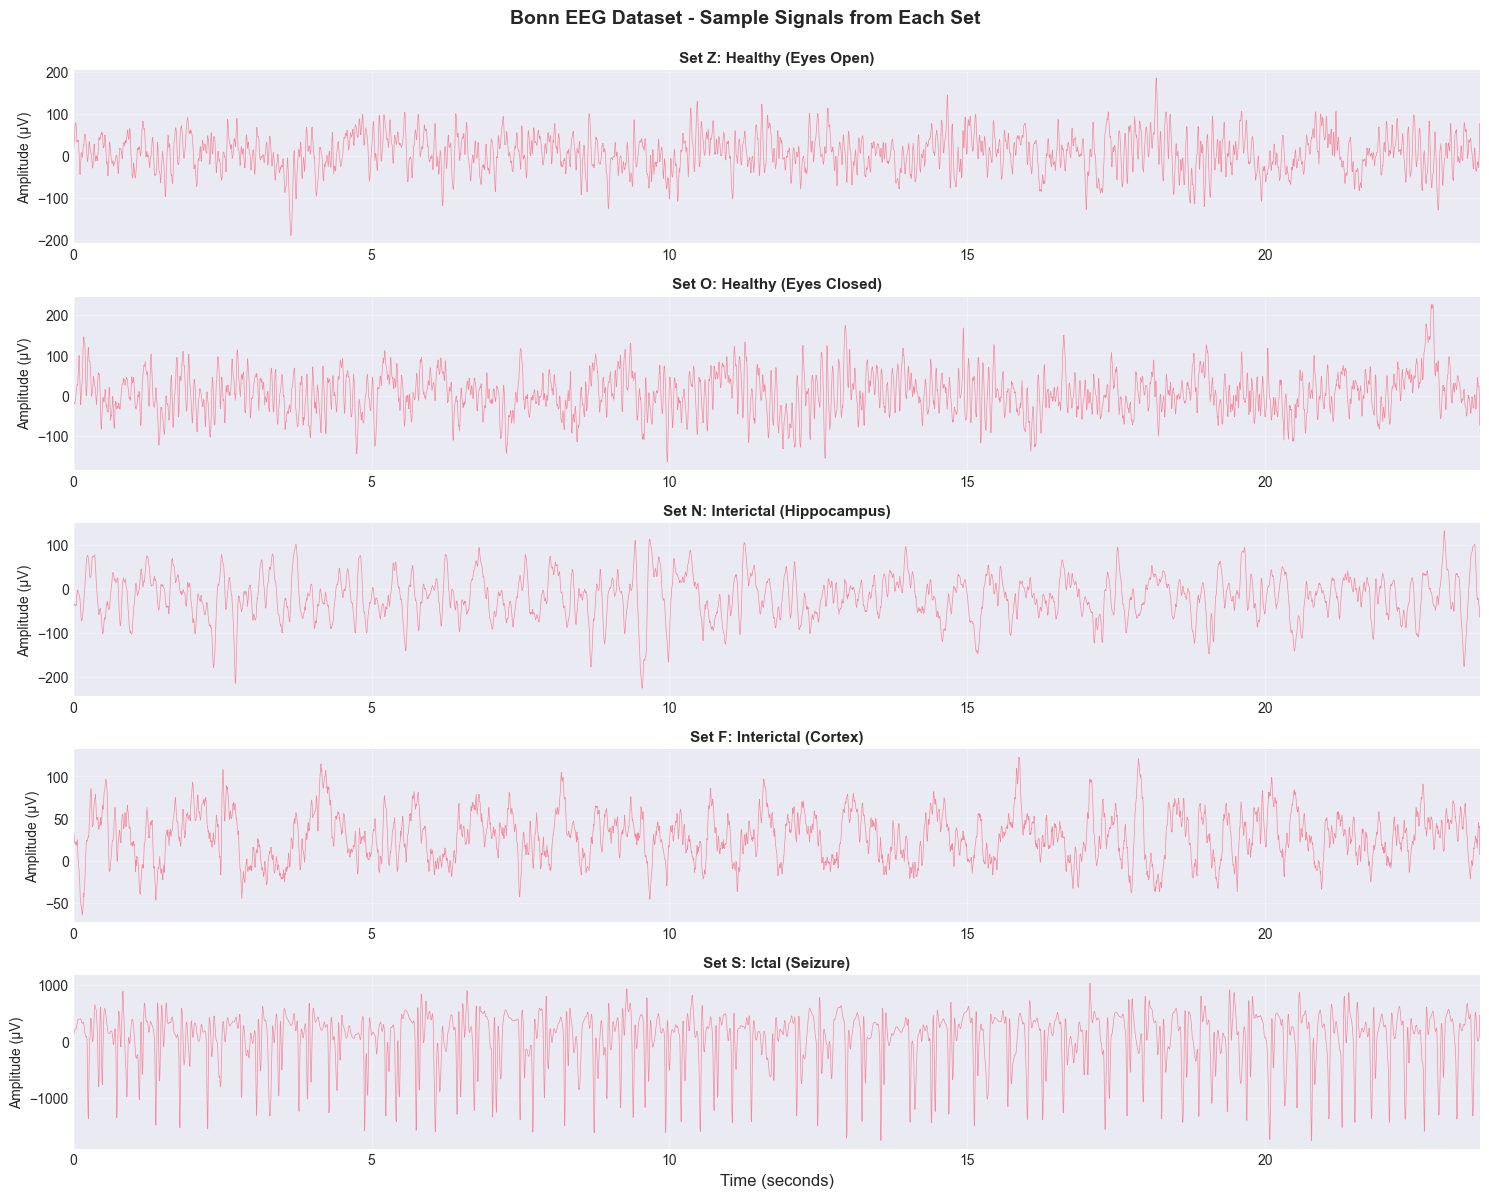

Saved figure: bonn_sample_signals.png


In [13]:
print("\n" + "="*80)
print("BONN DATASET VISUALIZATIONS")
print("="*80)

# Plot sample signals from each set
fig, axes = plt.subplots(len(bonn_sets), 1, figsize=(15, 12))

for idx, (set_name, description) in enumerate(bonn_sets.items()):
    if set_name in bonn_data:
        sample_signal = bonn_data[set_name][0]
        time = np.arange(len(sample_signal)) / BONN_SAMPLING_RATE
        
        axes[idx].plot(time, sample_signal, linewidth=0.5, alpha=0.8)
        axes[idx].set_ylabel('Amplitude (μV)', fontsize=10)
        axes[idx].set_title(f'Set {set_name}: {description}', 
                           fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xlim([0, BONN_DURATION])

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
plt.suptitle('Bonn EEG Dataset - Sample Signals from Each Set', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'bonn_sample_signals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: bonn_sample_signals.png")

In [14]:
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - BONN DATASET")
print("="*80)

# Compute statistics for each set
bonn_stats = []

for set_name in bonn_sets.keys():
    if set_name in bonn_data:
        data = bonn_data[set_name]
        
        for segment in data[:10]:  # Analyze first 10 segments
            features = compute_time_domain_features(segment)
            features['set'] = set_name
            features['description'] = bonn_sets[set_name]
            bonn_stats.append(features)

bonn_stats_df = pd.DataFrame(bonn_stats)

print("\nTime Domain Statistics by Set:")
print(bonn_stats_df.groupby('set')[['mean', 'std', 'skewness', 'kurtosis']].mean())


STATISTICAL ANALYSIS - BONN DATASET

Time Domain Statistics by Set:
          mean         std  skewness  kurtosis
set                                           
F    -7.369685  110.035081  0.995638  3.949788
N    -0.556993   57.421960 -0.061762  0.697205
O     7.901464   62.021845 -0.013338  0.277853
S     3.751574  350.926005 -0.305241  0.405446
Z   -12.089505   42.933429  0.010979  0.271785


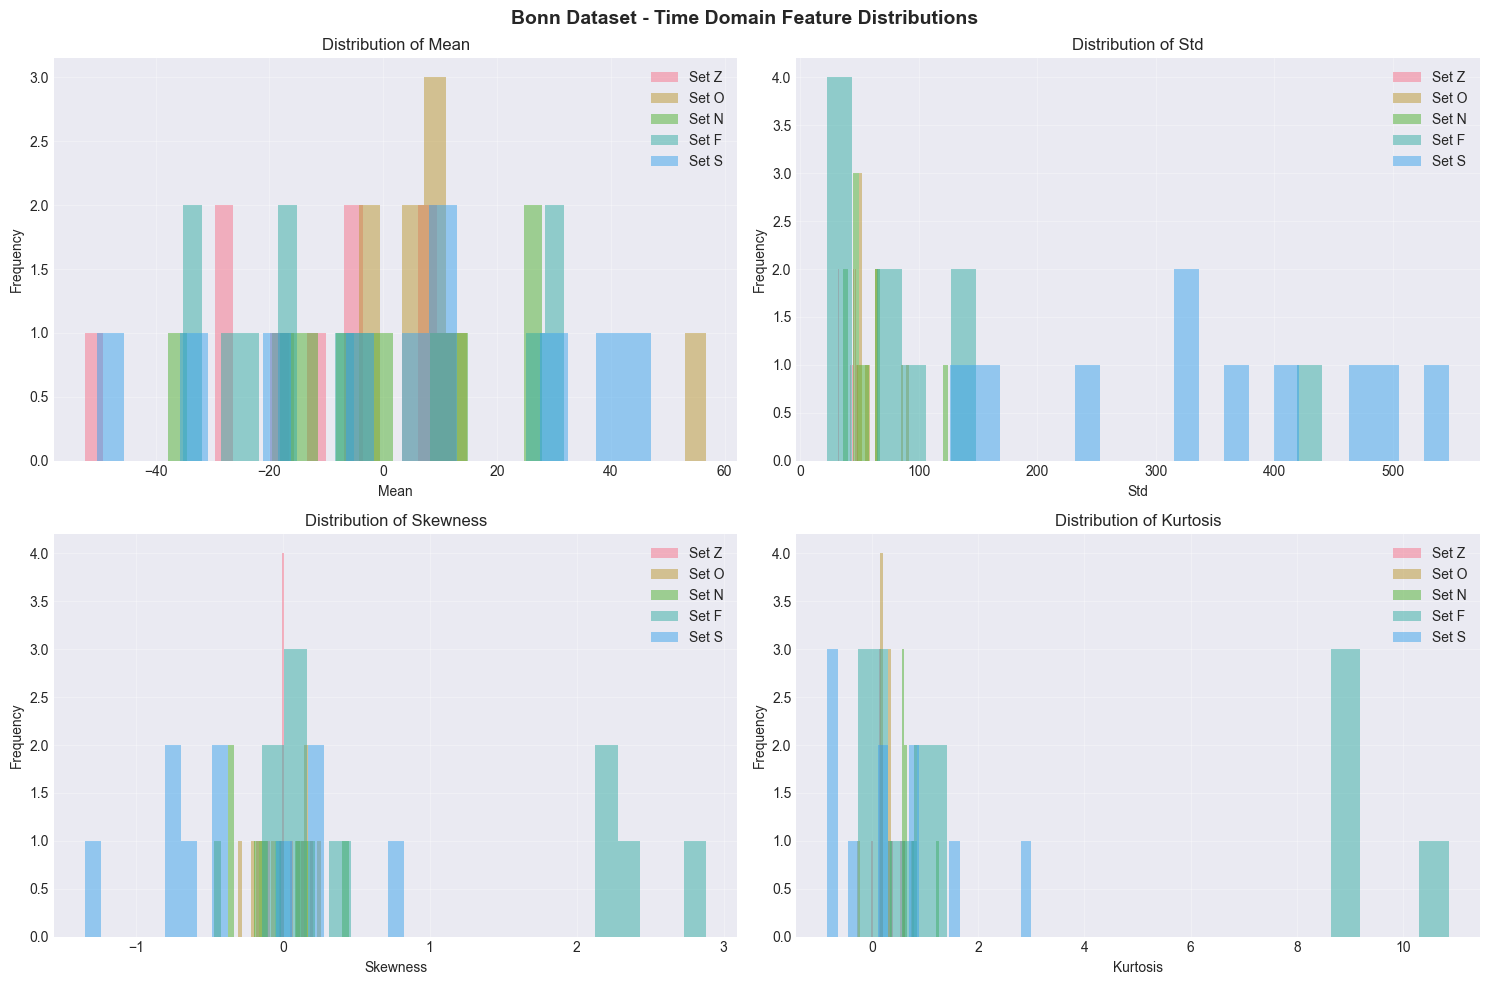

Saved figure: bonn_feature_distributions.png


In [15]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['mean', 'std', 'skewness', 'kurtosis']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for set_name in bonn_sets.keys():
        if set_name in bonn_data:
            subset = bonn_stats_df[bonn_stats_df['set'] == set_name]
            ax.hist(subset[metric], alpha=0.5, label=f'Set {set_name}', bins=20)
    
    ax.set_xlabel(metric.capitalize())
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {metric.capitalize()}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Bonn Dataset - Time Domain Feature Distributions', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'bonn_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: bonn_feature_distributions.png")


FREQUENCY ANALYSIS - BONN DATASET


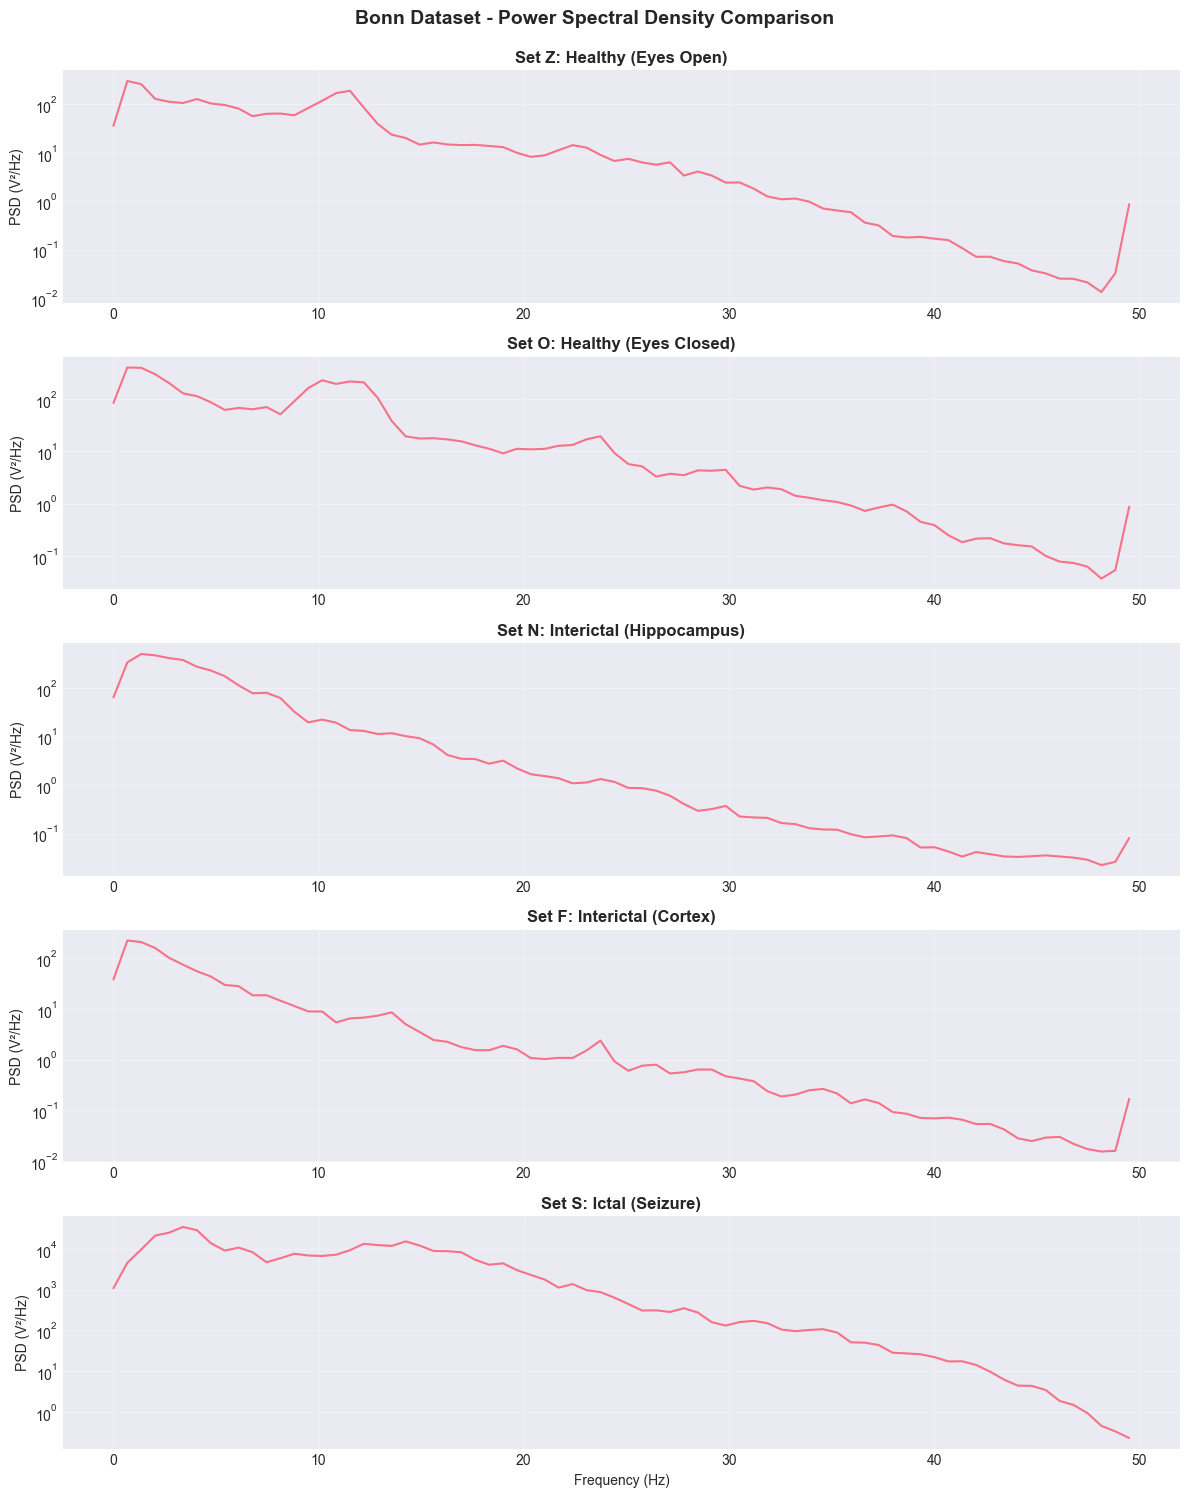

Saved figure: bonn_power_spectra.png


In [16]:
print("\n" + "="*80)
print("FREQUENCY ANALYSIS - BONN DATASET")
print("="*80)

# Plot power spectra for different sets
fig, axes = plt.subplots(len(bonn_sets), 1, figsize=(12, 15))

for idx, set_name in enumerate(bonn_sets.keys()):
    if set_name in bonn_data:
        sample = bonn_data[set_name][0]
        freqs, psd = compute_power_spectrum(sample, BONN_SAMPLING_RATE)
        
        mask = freqs <= 50
        axes[idx].semilogy(freqs[mask], psd[mask])
        axes[idx].set_ylabel('PSD (V²/Hz)')
        axes[idx].set_title(f'Set {set_name}: {bonn_sets[set_name]}', 
                           fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Frequency (Hz)')
plt.suptitle('Bonn Dataset - Power Spectral Density Comparison', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'bonn_power_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: bonn_power_spectra.png")

In [17]:
print("\n📊 Comparing Frequency Band Powers:")

band_power_comparison = []

for set_name in bonn_sets.keys():
    if set_name in bonn_data:
        sample = bonn_data[set_name][0]
        fig, band_powers = plot_power_spectrum(sample, BONN_SAMPLING_RATE,
                                               title=f'Set {set_name}: {bonn_sets[set_name]}')
        plt.savefig(FIGURES_DIR / f'bonn_set_{set_name}_spectrum.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        band_power_comparison.append({
            'set': set_name,
            'description': bonn_sets[set_name],
            'delta': band_powers[0],
            'theta': band_powers[1],
            'alpha': band_powers[2],
            'beta': band_powers[3],
            'gamma': band_powers[4]
        })

band_power_df = pd.DataFrame(band_power_comparison)
print(band_power_df)


📊 Comparing Frequency Band Powers:
  set               description         delta         theta         alpha  \
0   Z       Healthy (Eyes Open)    480.979660    296.319993    516.656734   
1   O     Healthy (Eyes Closed)    777.844536    250.025847    791.315122   
2   N  Interictal (Hippocampus)   1199.596838    530.746760    107.384654   
3   F       Interictal (Cortex)    420.062375    106.577923     39.909764   
4   S           Ictal (Seizure)  51071.789113  39709.905644  40719.185428   

           beta       gamma  
0    172.214569    8.173616  
1    186.469118   12.850205  
2     44.299417    1.524799  
3     26.828555    2.201799  
4  59141.308776  833.731699  


In [ ]:
# ============================================================================
# LOAD AND EXPLORE CHB-MIT DATASET
# ============================================================================

In [18]:
print("\n" + "="*80)
print("CHB-MIT EEG DATASET EXPLORATION")
print("="*80)

# Load a sample from CHB-MIT
raw_chb = load_chb_mit_sample(CHB_MIT_PATH, patient='chb01', file_num=0)

if raw_chb is not None:
    print(f"\n✓ Successfully loaded CHB-MIT sample")
    print(f"  - Sampling Rate: {raw_chb.info['sfreq']} Hz")
    print(f"  - Number of Channels: {len(raw_chb.ch_names)}")
    print(f"  - Duration: {raw_chb.times[-1]:.2f} seconds")
    print(f"  - Channel Names: {raw_chb.ch_names[:5]}... (showing first 5)")
    
    # Get data
    data_chb, times_chb = raw_chb[:, :int(10 * raw_chb.info['sfreq'])]  # First 10 seconds


CHB-MIT EEG DATASET EXPLORATION
Loading: chb01_01.edf

✓ Successfully loaded CHB-MIT sample
  - Sampling Rate: 256.0 Hz
  - Number of Channels: 23
  - Duration: 3600.00 seconds
  - Channel Names: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3']... (showing first 5)



CHB-MIT DATASET VISUALIZATIONS


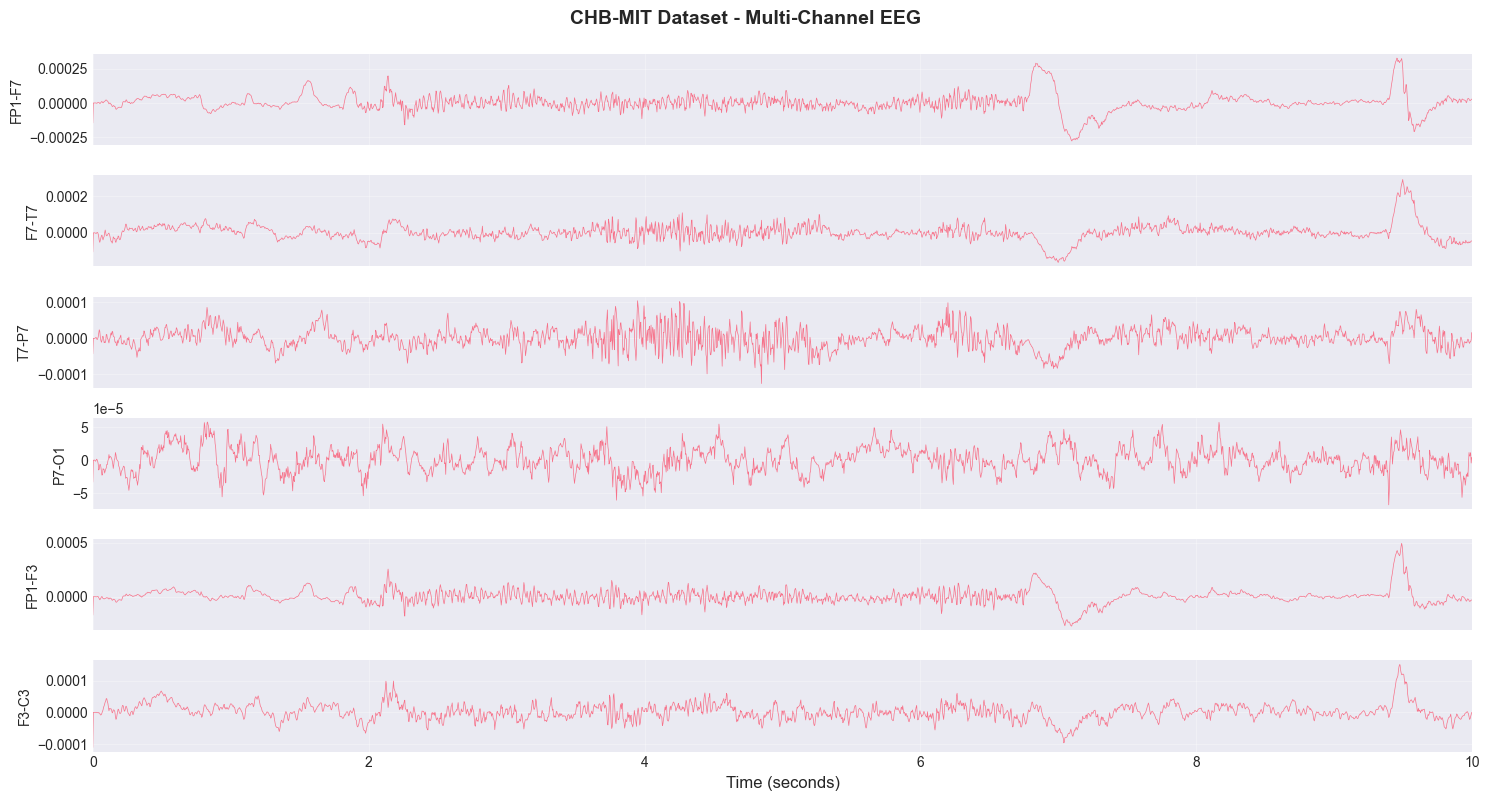

✓ Saved figure: chb_mit_multichannel.png


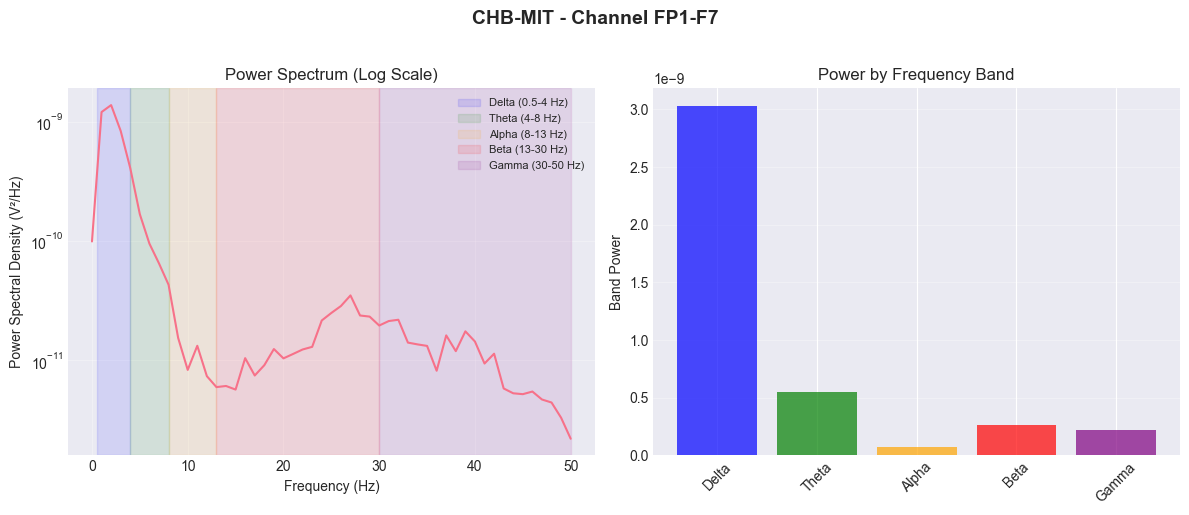

Saved figure: chb_mit_spectrum.png


In [19]:
print("\n" + "="*80)
print("CHB-MIT DATASET VISUALIZATIONS")
print("="*80)

# Plot multiple channels
n_channels_to_plot = min(6, len(raw_chb.ch_names))
fig = plot_eeg_signals(data_chb[:n_channels_to_plot], 
                        raw_chb.info['sfreq'],
                        channels=raw_chb.ch_names[:n_channels_to_plot],
                        duration=10,
                        title='CHB-MIT Dataset - Multi-Channel EEG')
plt.savefig(FIGURES_DIR / 'chb_mit_multichannel.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved figure: chb_mit_multichannel.png")

# Analyze single channel in detail
channel_idx = 0
channel_data = data_chb[channel_idx]

fig, band_powers = plot_power_spectrum(channel_data, 
                                        raw_chb.info['sfreq'],
                                        title=f'CHB-MIT - Channel {raw_chb.ch_names[channel_idx]}')
plt.savefig(FIGURES_DIR / 'chb_mit_spectrum.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: chb_mit_spectrum.png")

In [20]:
print("\n" + "="*80)
print("DATASET COMPARISON")
print("="*80)

comparison_data = {
    'Characteristic': [
        'Sampling Rate', 
        'Channels', 
        'Duration per Segment',
        'Total Segments/Files',
        'Data Format'
    ],
    'Bonn Dataset': [
        '173.61 Hz',
        '1 (Single channel)',
        '23.6 seconds',
        '500 (100 per set)',
        'Text files'
    ],
    'CHB-MIT Dataset': [
        '256 Hz',
        '23-26 channels',
        'Variable (hours)',
        '664 files',
        'EDF (European Data Format)'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))


DATASET COMPARISON


      Characteristic       Bonn Dataset            CHB-MIT Dataset
       Sampling Rate          173.61 Hz                     256 Hz
            Channels 1 (Single channel)             23-26 channels
Duration per Segment       23.6 seconds           Variable (hours)
Total Segments/Files  500 (100 per set)                  664 files
         Data Format         Text files EDF (European Data Format)


In [ ]:
# ============================================================================
# KEY FINDINGS AND OBSERVATIONS
# ============================================================================

In [22]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

findings = """
🔍 KEY OBSERVATIONS:

1. BONN DATASET:
   ✓ Clear distinction between sets S (seizure) and others
   ✓ Seizure signals show higher amplitude and irregular patterns
   ✓ Healthy signals (Z, O) are more rhythmic and lower amplitude
   ✓ Power spectrum shows increased activity across all bands during seizures
   
2. CHB-MIT DATASET:
   ✓ Multi-channel recordings provide spatial information
   ✓ Higher sampling rate (256 Hz) captures more detail
   ✓ Longer duration recordings require windowing strategies
   ✓ Channel variability suggests need for channel selection or averaging

3. TIME SERIES CHARACTERISTICS:
   ✓ Non-stationary signals requiring segmentation
   ✓ Strong temporal dependencies within seizure events
   ✓ Class imbalance (seizures are rare events)
   ✓ Need for robust preprocessing (filtering, normalization)

4. PREPROCESSING RECOMMENDATIONS:
   ✓ Bandpass filtering (0.5-50 Hz) to remove noise
   ✓ Sliding window approach (4-second windows with 50% overlap)
   ✓ Z-score normalization per channel
   ✓ Data augmentation to handle class imbalance

5. FEATURE ENGINEERING DIRECTIONS:
   ✓ Statistical features show clear differences between classes
   ✓ Frequency band powers are discriminative features
   ✓ RQA features will capture nonlinear dynamics
   ✓ Deep learning can learn features automatically
"""

print(findings)


KEY FINDINGS

🔍 KEY OBSERVATIONS:

1. BONN DATASET:
   ✓ Clear distinction between sets S (seizure) and others
   ✓ Seizure signals show higher amplitude and irregular patterns
   ✓ Healthy signals (Z, O) are more rhythmic and lower amplitude
   ✓ Power spectrum shows increased activity across all bands during seizures
   
2. CHB-MIT DATASET:
   ✓ Multi-channel recordings provide spatial information
   ✓ Higher sampling rate (256 Hz) captures more detail
   ✓ Longer duration recordings require windowing strategies
   ✓ Channel variability suggests need for channel selection or averaging

3. TIME SERIES CHARACTERISTICS:
   ✓ Non-stationary signals requiring segmentation
   ✓ Strong temporal dependencies within seizure events
   ✓ Class imbalance (seizures are rare events)
   ✓ Need for robust preprocessing (filtering, normalization)

4. PREPROCESSING RECOMMENDATIONS:
   ✓ Bandpass filtering (0.5-50 Hz) to remove noise
   ✓ Sliding window approach (4-second windows with 50% overlap)
   

In [ ]:
# ============================================================================
# SAVE SUMMARY STATISTICS
# ============================================================================

In [23]:
print("\n" + "="*80)
print("SAVING SUMMARY DATA")
print("="*80)

# Save Bonn statistics
bonn_stats_df.to_csv(PROCESSED_DIR / 'bonn_statistics.csv', index=False)
print("✓ Saved: bonn_statistics.csv")

# Save band power comparison
band_power_df.to_csv(PROCESSED_DIR / 'bonn_band_powers.csv', index=False)
print("✓ Saved: bonn_band_powers.csv")

# Save dataset comparison
comparison_df.to_csv(PROCESSED_DIR / 'dataset_comparison.csv', index=False)
print("✓ Saved: dataset_comparison.csv")



SAVING SUMMARY DATA
✓ Saved: bonn_statistics.csv
✓ Saved: bonn_band_powers.csv
✓ Saved: dataset_comparison.csv
